# Example Notebook #4 - Options Implied Portfolios and Strategy

In [179]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from datetime import datetime as dt
from datetime import timedelta
from pandas.tseries.offsets import BDay
%load_ext autoreload
%autoreload 2
plt.style.use('bmh')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
from portfolio_swissknife import portfolio as pf
from portfolio_swissknife import models as rm

In [181]:
securities = ['AAPL', 'MSFT', 'TGT']
pf1 = pf.Portfolio(securities)
pf1.set_period(('2012-01-01',(dt.today() - BDay(1)).strftime('%Y-%m-%d')))
pf1.get_prices()
pf1.set_discount('^TNX')

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


In [183]:
securities = ['AAPL', 'MSFT', 'TGT']
pcm1 = rm.PricingModel(pf1)
pcm1.set_period(('2012-01-01',(dt.today() - BDay(1)).strftime('%Y-%m-%d')))
pcm1.set_pricing_model('BS', 252)
pcm1.price_theoretical_option_chain(tenor_periods = 24, K_std_range = 2)

In [193]:
pcm1.get_options_data(std_range=2)

AttributeError: 'PricingModel' object has no attribute 'set_theoretical_pricing_model'

In [194]:
opf = pf.OptionsPortfolio(securities)
opf.set_theoretical_pricing_model(pcm1)

In [56]:
sigma = np.std(pf1.returns[:, -252:],0)*np.sqrt(252)
s_0 = pf1.prices.iloc[-1,:].values

In [12]:
import yfinance as yf

In [13]:
test_ticker = 'AAPL'
def empirical_options_chain(symbol):
    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt['expirationDate'] = e
        options = options.append(opt, ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + timedelta(days = 1)
    options['dte'] = (options['expirationDate'] - dt.today()).dt.days / 365
    
    # Boolean column if the option is a CALL
    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)
    
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['mark'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask
    
    # Drop unnecessary and meaningless columns
    options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])
    
    return options

In [17]:
df = empirical_options_chain(test_ticker)

<AxesSubplot:ylabel='Frequency'>

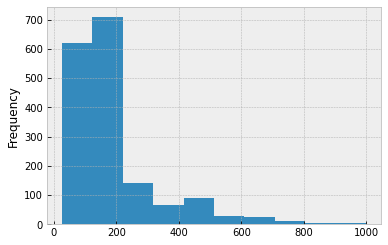

In [177]:
df1 = df.loc[df['strike'] < s_0[0] + 2*sigma[0]*s_0[0]]
df1 = df1.loc[df1['strike'] > s_0[0] - 2*sigma[0]*s_0[0]]
df1 = df1.loc[df1['impliedVolatility'] > 0.001]
df1 = df1.loc[df1['volume'] > 2]
df1 = df1.loc[df1['CALL'] == 1]

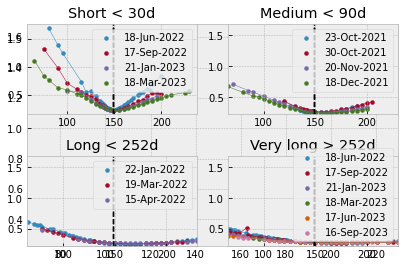

In [189]:
fig = plt.figure(1,figsize=(15,10))
cols = 2
rows = 4 // cols
rows += 4 % cols
position = range(1, 4 + 1)

ax.set_xlim(min(df1['strike']),max(df1['strike']))
ax.set_ylim(min(df1['impliedVolatility']), max(df1['impliedVolatility']))

ax = fig.add_subplot(rows, cols, position[0]) 
ax.set_title('Short < 30d')
count = 0
for name, gr in df1.groupby('expirationDate'):
    tenor = (name - dt.today()).days    
    grp = gr.sort_values(by = 'strike')
    if tenor > 30 and count < 1:
        count += 1
        ax = fig.add_subplot(rows,cols,position[count])
        ax.set_title('Medium < 90d')
        ax.set_xlim(min(df1['strike']),max(df1['strike']))
        ax.set_ylim(min(df1['impliedVolatility']), max(df1['impliedVolatility']))
        legend = []
        
    if tenor > 91 and count < 2:
        count += 1
        ax = fig.add_subplot(rows,cols,position[count])
        ax.set_title('Long < 252d')
        ax.set_xlim(min(df1['strike']),max(df1['strike']))
        ax.set_ylim(min(df1['impliedVolatility']), max(df1['impliedVolatility']))
        
        legend = []
    if tenor > 252 and count < 3:
        count += 1
        ax = fig.add_subplot(rows,cols,position[count])
        ax.set_title('Very long > 252d')
        ax.set_xlim(min(df1['strike']),max(df1['strike']))
        ax.set_ylim(min(df1['impliedVolatility']), max(df1['impliedVolatility']))
        
        legend = []
    
    ax.scatter(grp['strike'], grp['impliedVolatility'], s = 15)
    ax.plot(grp['strike'], grp['impliedVolatility'], linewidth = 0.5, label = '_nolegend_')
    
    legend.append(name.strftime('%d-%b-%Y'))
    ax.axvline(s_0[0],color = 'black', linewidth = 1.4, alpha = 0.7, linestyle ='--', label = '_nolegend_')
    ax.legend(legend)
    fig = plt.gcf()
    fig.tight_layout()